In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END 
from langgraph.graph.message import add_messages
import os
from dotenv import load_dotenv
load_dotenv()

## load the Groq API key
groq_api_key=os.environ['GROQ_API_KEY']


In [2]:
## Working with Tools

from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results= 1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

In [3]:
wiki_tool.invoke("Who is Lewis Hamilton")

"Page: Lewis Hamilton\nSummary: Sir Lewis Carl Davidson Hamilton (born 7 January 1985) is a British racing driver, who is contracted to compete in Formula One for Ferrari. Hamilton has won a joint-record seven Formula One World Drivers' Championship titles—tied with Michael Schumacher—and holds the re"

In [4]:
tools = [wiki_tool]

In [5]:
#LangGraph App

class State(TypedDict):
    messages:Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

In [6]:
from langgraph.graph import StateGraph, START, END 
from langchain_groq import ChatGroq


llm = ChatGroq(groq_api_key= 
               groq_api_key, model_name = "Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x1112e0ad0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x1112e2660>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm_with_tools = llm.bind_tools(tools = tools)

In [8]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [9]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START,"chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot",tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [10]:
graph=graph_builder.compile()

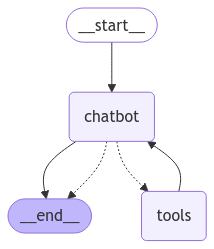

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
user_input = "Hi there, my name is Yusuf"

events = graph.stream({"messages": [("user", user_input)]}, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Hi there, my name is Yusuf
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_py4b)
 Call ID: call_py4b
  Args:
    query: Yusuf
================================= Tool Message =================================
Name: wikipedia

Page: Yusuf
Summary: Yusuf (Arabic: يوسف Yūsuf) is a male name meaning "God increases" (in piety, power and influence). It is the Arabic equivalent of the Hebrew name Yosef and the English name Joseph. It is widely used in many parts of the world by Arabs of all Abrahamic religions, including Middle
================================== Ai Message ==================================

That's interesting!  



Are there any specific things you'd like to know about the name Yusuf?
